In [49]:
import cv2                 # OpenCV (이미지 처리 도구)
import numpy as np         # 행렬 계산 (이미지를 숫자로 다룸)
import pyautogui           # 화면 캡처 도구
import easyocr             # OCR (글자 인식 도구)
import pyperclip           # 클립보드 복사 도구
import matplotlib.pyplot as plt # 이미지를 화면에 보여주는 도구

# EasyOCR 리더기 미리 로딩 (한국어, 영어 설정)
# * 처음 실행 시 모델 파일을 다운로드하느라 시간이 좀 걸립니다. *
# gpu=False는 컴퓨터에 그래픽카드가 없거나 설정이 안 된 경우를 대비한 안전장치입니다.
reader = easyocr.Reader(['ko', 'en'], gpu=False) 

print("✅ 라이브러리 로딩 및 OCR 준비 완료!")


Using CPU. Note: This module is much faster with a GPU.


✅ 라이브러리 로딩 및 OCR 준비 완료!


In [50]:
# 1. 화면 전체 캡처
screenshot = pyautogui.screenshot()

# 2. 캡처한 이미지를 컴퓨터가 이해하는 숫자 배열(NumPy)로 변환
img_frame = np.array(screenshot)

# 3. 색상 보정 (Pillow는 RGB 순서, OpenCV는 BGR 순서를 씁니다)
# 이 과정을 안 거치면 캡처한 사진 색깔이 푸르딩딩하게 보입니다.
img_frame = cv2.cvtColor(img_frame, cv2.COLOR_RGB2BGR)

print(f"✅ 화면 캡처 완료! 이미지 크기: {img_frame.shape}")
# 결과 예시: (1080, 1920, 3) -> 세로 1080, 가로 1920, 색상채널 3개


✅ 화면 캡처 완료! 이미지 크기: (1080, 1920, 3)


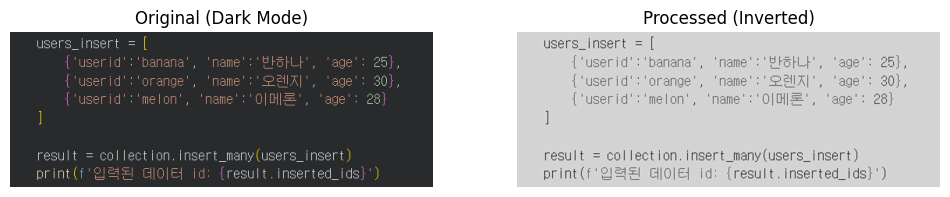

✅ 처리가 완료되었습니다! 글자가 선명한 검은색으로 보이나요?


In [51]:
# [Cell 3 통합본] 전처리 방식 변경 (다크모드 코드 인식용)

# 1. ROI 선택
rect = cv2.selectROI("Select Area", img_frame, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w, h = rect

if w > 0 and h > 0:
    # 2. 자르기
    cropped_img = img_frame[y:y+h, x:x+w]
    
    # 3. 전처리 수정 (이진화 제거, 반전 추가)
    
    # (1) 확대: 글자를 크게 만듦 (여전히 유효함)
    processed_img = cv2.resize(cropped_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    
    # (2) 흑백 변환
    gray = cv2.cvtColor(processed_img, cv2.COLOR_BGR2GRAY)
    
    # (3) 색상 반전 (Invert) ★ 핵심 ★
    # 다크모드(검은 배경)를 흰 배경으로, 글씨를 검은색으로 뒤집습니다.
    # OCR은 보통 '흰 종이에 검은 글씨'를 가장 잘 읽습니다.
    inverted = cv2.bitwise_not(gray)
    
    # (4) 이진화(Threshold)는 삭제!
    # 색깔 있는 코드가 지워지는 주범이므로 뺍니다.
    # 대신 반전된 이미지(inverted)를 최종 결과물(binary)로 씁니다.
    binary = inverted 
    
    # 4. 결과 비교
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title("Original (Dark Mode)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(binary, cmap='gray')
    plt.title("Processed (Inverted)")
    plt.axis('off')
    
    plt.show()
    
    print(f"✅ 처리가 완료되었습니다! 글자가 선명한 검은색으로 보이나요?")
    
else:
    print("⚠️ 영역 선택이 취소되었습니다.")

In [52]:
# [Cell 4 대체] 좌표를 분석하여 들여쓰기(Indentation) 복구하기

# -------------------------------------------------------------
# 1. 들여쓰기 복구 함수 정의 (이 부분은 이해 안 가셔도 괜찮아요! 도구처럼 쓰세요)
# -------------------------------------------------------------
def get_text_with_indentation(result_list, space_width=20):
    """
    OCR 결과에서 좌표(x값)를 분석해 들여쓰기를 포함한 문자열을 만듭니다.
    :param result_list: reader.readtext()의 결과 (detail=1)
    :param space_width: 스페이스바 1개당 픽셀 너비 (보통 2배 확대시 20~30 정도)
    """
    if not result_list:
        return ""

    # 1. Y축(세로) 좌표를 기준으로 줄(Line) 나누기
    lines = []
    # 첫 번째 글자의 정보를 기준으로 시작
    current_line = [result_list[0]]
    # 이전 글자의 Y중심값
    prev_y_center = (result_list[0][0][0][1] + result_list[0][0][2][1]) / 2 

    for i in range(1, len(result_list)):
        bbox, text, conf = result_list[i]
        # 현재 글자의 Y중심값
        y_center = (bbox[0][1] + bbox[2][1]) / 2
        
        # 줄 바꿈 판단 (Y 위치가 15픽셀 이상 차이나면 새로운 줄로 간주)
        if abs(y_center - prev_y_center) > 15:
            lines.append(current_line)
            current_line = []
        
        current_line.append(result_list[i])
        prev_y_center = y_center
    
    # 마지막 줄 추가
    if current_line:
        lines.append(current_line)

    # 2. 각 줄마다 들여쓰기 계산하기
    final_output = ""
    
    # 전체 텍스트 중 가장 왼쪽에 있는 글자의 X좌표 찾기 (기준점)
    min_x = min([line[0][0][0][0] for line in lines])

    for line in lines:
        # 같은 줄에 있는 글자들은 X좌표 순서대로 정렬
        line.sort(key=lambda x: x[0][0][0])
        
        # 이 줄의 첫 번째 글자가 기준점(min_x)보다 얼마나 떨어져 있나?
        first_word_x = line[0][0][0][0]
        indent_pixels = first_word_x - min_x
        
        # 픽셀 차이를 스페이스바 개수로 환산 (정수형 변환)
        num_spaces = int(indent_pixels / space_width)
        
        # 들여쓰기 공백 생성
        indent_str = " " * num_spaces
        
        # 해당 줄의 글자들 합치기
        line_text = " ".join([item[1] for item in line])
        
        # 결과에 추가 (들여쓰기 + 글자 + 줄바꿈)
        final_output += indent_str + line_text + "\n"

    return final_output

# -------------------------------------------------------------
# 2. 실제 실행 코드
# -------------------------------------------------------------

# 'binary' 이미지가 있으면 그거 쓰고, 없으면 원본(cropped_img) 사용
target_image = binary if 'binary' in locals() else cropped_img

print("⏳ 들여쓰기를 포함하여 텍스트를 분석 중입니다...")

# ★ 중요: detail=1로 설정해야 좌표 정보를 받아옵니다!
raw_result = reader.readtext(target_image, detail=1)

# 위에서 만든 함수로 '들여쓰기 된 텍스트' 생성
# space_width=25 숫자를 조절하면 들여쓰기 칸 수를 조절할 수 있습니다.
formatted_text = get_text_with_indentation(raw_result, space_width=25)

print("-" * 30)
print("🔍 [들여쓰기 복원 결과]")
print(formatted_text)
print("-" * 30)

# 클립보드 복사
if formatted_text.strip():
    pyperclip.copy(formatted_text)
    print("✅ 코드가 클립보드에 복사되었습니다!")
else:
    print("⚠️ 인식된 텍스트가 없습니다.")

⏳ 들여쓰기를 포함하여 텍스트를 분석 중입니다...


c:\wahwah\projects\semi\yuzyproject-aimodels\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


------------------------------
🔍 [들여쓰기 복원 결과]
users_insert = [
   { userid barana rarre 반하나- age 25}
   { userid orange rarre 오렌지 age 30}
   { userid Iielor7 rame 이메론 age 28}
result = Collectioninsert_many(users_insert)
print (f '입력된 데이터 id; {resultinserted_ids}' )

------------------------------
✅ 코드가 클립보드에 복사되었습니다!


In [ ]:
rPsult - Collectiorfindl:: ) data il result ; print (data) tii